# Introduction Deep Learning

<img src='https://github.com/retkowsky/images/blob/master/AzureMLservicebanniere.png?raw=true'>

https://en.wikipedia.org/wiki/MNIST_database

Exemple **MNIST** (Modified National Institute of Standards and Technology.<br>
Pour représenter cette image, nous allons utiliser un vecteur binaire de **784 variables (28x28)**. La ième valeur du vecteur prendra la valeur 0 ou 1 suivant si le ième pixel dans l'image est blanc ou noir.

Un algorithme de **Deep Learning** va commencer par subdiviser ce problème complexe, en sous problèmes plus simple à résoudre. Pour cela, il va prendre des sous parties de l'image, par exemple, des groupements de pixels de 5x5, 4x4, ou 3x3, et opérer une fonction afin d'extraire des motifs dans cette sous-partie (on parle d'opération de convolution).
Ainsi, différentes transformations sont opérées sur différentes parties de l'image d'entrée, retravaillées puis combinées à la couche suivante, etc., etc. permettant ainsi de générer des cartographies des pixels importants dans l'image.<br>


<img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png">

<img src="https://msdnshared.blob.core.windows.net/media/2016/04/042816_1315_Unepremirei32.png">

L'illustration ci-dessus met en évidence la succession des couches, et l'extraction de l'information qu'elles réalisent. Elle permet aussi de refléter la hiérarchie entre les couches :

La première se focalise sur une petite portion de l'image (5x5 par exemple).
La seconde récupère le résultat de toutes les portions précédentes et essaye de repérer de nouveaux indicateurs.
La troisième va encore plus loin, en suivant le même principe, permettant d'identifier assez précisément les contours du visage.
Vous l'aurez donc compris, chaque couche est génératrice de variables. Chaque couche va venir rajouter son lot de variable issues de la combinaison des précédentes. C'est ici qu'intervient la véritable différence entre un réseau de neurones « classique » et un algorithme de Deep Learning.

Cette faculté à générer des variables, qui plus est, très pertinentes dans un problème donné, permet à l'algorithme de découvrir des indicateurs de « haut niveaux » générant un fort pouvoir prédictif.

En combinant toutes ces informations issues des différentes couches, correctement pondérées, nous obtenons un système capable d'identifier les éléments importants d'une image, dans le but final de prédire la sortie avec la plus forte probabilité d'être correcte.

## Partitionnement des données
On va utiliser une partie des données pour apprendre (60 000) et le reste (10 000) pour vérifier si notre algorithme est correct. <br>Nous utilisons KERAS qui est une surcouche à TensorFlow.

In [37]:
import sys
sys.version

'3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) \n[GCC 7.3.0]'

In [38]:
import scipy, matplotlib, pandas, sklearn
import numpy as np
import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

In [39]:
print("Azure ML version =", azureml.core.VERSION)

Azure ML version = 1.13.0


In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from keras.utils import np_utils

In [41]:
import keras
print("Version Keras =", keras.__version__)

Version Keras = 2.3.1


In [42]:
import azureml.core
print("Azure ML version =", azureml.core.VERSION)

Azure ML version = 1.13.0


In [43]:
# Rappel des infos du workspace Azure ML service
from azureml.core import Workspace

ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Resource group: ' + ws.resource_group, sep='\n')

Workspace name: workshopAML2020
Azure region: westeurope
Resource group: workshopAML2020-rg


In [44]:
from azureml.core import experiment
experiment = Experiment(workspace=ws, name="Exemple9-DLsimuls")

In [45]:
nb_classes = 10 # On doit reconnaitre 10 chiffres différents

# Affichage du nombre de lignes
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
print ('1. Training :', training_images.shape[0])
print ('2. Test :', test_images.shape[0])

1. Training : 60000
2. Test : 10000


## Visualisation

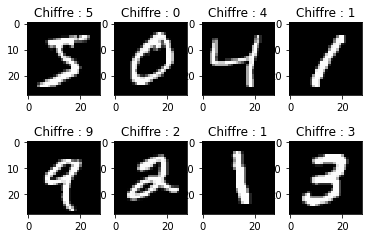

In [46]:
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(training_images[i], cmap='gray', interpolation='none')
    plt.title("Chiffre : {}".format(training_labels[i]))

## Traitement
Les images sont représentées par 28 pixels sur 28 pixels.
Nous allons donc générer un réseau de 784 neurones (28 X 28).
En sortie nous voulons 10 neurones (= les 10 chiffres de 0 à 9).

Nous allons convertir les images qui sont sous forme de tableaux 28 par 28 en un vecteur de longueur 784.
Nous allons diviser les valeurs par 255 pour que notre vecteur ne contienne que des données entre 0 et 1.<br>
Au final nous allons convertir les classes de chiffres en catégories.

In [47]:
training_images = training_images.reshape(60000, 784)
test_images = test_images.reshape(10000, 784)
training_images = training_images.astype('float32')
test_images = test_images.astype('float32')
training_images /= 255
test_images /= 255

training_labels_categories = np_utils.to_categorical(training_labels, nb_classes)
test_labels_categories = np_utils.to_categorical(test_labels, nb_classes)

## Estimation
Nous allons estimer un réseau avec une première couche de 500 neurones et une couche de sortie de 10 neurones.<br>
Autres paramétres :
- Fonction d’optimisation : SGD (Stochastique Gradient Descent) et « vitesse d’apprentissage » 0.5
- Taille du batch : 500 (nombre d’images utilisées pour entrainer le réseau)
- Nombre d’epoch : 1 (un epoch = un apprentissage sur toutes les données)


## Modèle 1

In [48]:
run = experiment.start_logging(snapshot_directory=None)

In [49]:
model = Sequential()
model.add(Dense(100, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

bs=500
epochs=1

model.compile(loss='categorical_crossentropy', optimizer=SGD(0.5), metrics=['accuracy'])

history = model.fit(training_images, training_labels_categories, batch_size=bs, epochs=epochs,
                    verbose=1, validation_data=(test_images, test_labels_categories))
score = model.evaluate(test_images, test_labels_categories, verbose=0)

run.log('Accuracy', score[1]) 
run.log('BatchSize', bs)
run.log('epochs', epochs)
print()
print('Accuracy=', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 2s 32us/step - loss: 0.5049 - accuracy: 0.8492 - val_loss: 0.2661 - val_accuracy: 0.9205

Accuracy= 0.9204999804496765


In [50]:
run.complete()

## Modèle 2

In [52]:
run = experiment.start_logging(snapshot_directory=None)

In [53]:
model = Sequential()
model.add(Dense(100, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

bs=800
epochs=10

model.compile(loss='categorical_crossentropy', optimizer=SGD(0.5), metrics=['accuracy'])

history = model.fit(training_images, training_labels_categories, batch_size=bs, epochs=epochs,
                    verbose=1, validation_data=(test_images, test_labels_categories))
score = model.evaluate(test_images, test_labels_categories, verbose=0)

run.log('Accuracy', score[1]) 
run.log('BatchSize', bs)
run.log('epochs', epochs)

print()
print('Accuracy=', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 9us/step - loss: 0.6156 - accuracy: 0.8148 - val_loss: 0.3080 - val_accuracy: 0.9133
Epoch 2/10
60000/60000 [==============================] - 0s 6us/step - loss: 0.2788 - accuracy: 0.9193 - val_loss: 0.2352 - val_accuracy: 0.9334
Epoch 3/10
60000/60000 [==============================] - 0s 5us/step - loss: 0.2248 - accuracy: 0.9356 - val_loss: 0.2026 - val_accuracy: 0.9425
Epoch 4/10
60000/60000 [==============================] - 0s 5us/step - loss: 0.1910 - accuracy: 0.9458 - val_loss: 0.1772 - val_accuracy: 0.9478
Epoch 5/10
60000/60000 [==============================] - 0s 5us/step - loss: 0.1681 - accuracy: 0.9528 - val_loss: 0.1617 - val_accuracy: 0.9512
Epoch 6/10
60000/60000 [==============================] - 0s 5us/step - loss: 0.1510 - accuracy: 0.9567 - val_loss: 0.1444 - val_accuracy: 0.9568
Epoch 7/10
60000/60000 [==============================] - 0s 5us/step - lo

In [54]:
run.complete()

## Modèle 3

In [55]:
run = experiment.start_logging(snapshot_directory=None)

In [56]:
model = Sequential()
model.add(Dense(100, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

bs=900
epochs=20

model.compile(loss='categorical_crossentropy', optimizer=SGD(0.5), metrics=['accuracy'])

history = model.fit(training_images, training_labels_categories, batch_size=bs, epochs=epochs,
                    verbose=1, validation_data=(test_images, test_labels_categories))
score = model.evaluate(test_images, test_labels_categories, verbose=0)

run.log('Accuracy', score[1]) 
run.log('BatchSize', bs)
run.log('epochs', epochs)

print()
print('Accuracy=', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 0s 8us/step - loss: 0.6485 - accuracy: 0.8043 - val_loss: 0.3136 - val_accuracy: 0.9108
Epoch 2/20
60000/60000 [==============================] - 0s 5us/step - loss: 0.2922 - accuracy: 0.9172 - val_loss: 0.2437 - val_accuracy: 0.9317
Epoch 3/20
60000/60000 [==============================] - 0s 5us/step - loss: 0.2363 - accuracy: 0.9325 - val_loss: 0.2203 - val_accuracy: 0.9365
Epoch 4/20
60000/60000 [==============================] - 0s 5us/step - loss: 0.2024 - accuracy: 0.9433 - val_loss: 0.1886 - val_accuracy: 0.9442
Epoch 5/20
60000/60000 [==============================] - 0s 5us/step - loss: 0.1791 - accuracy: 0.9499 - val_loss: 0.1727 - val_accuracy: 0.9509
Epoch 6/20
60000/60000 [==============================] - 0s 5us/step - loss: 0.1620 - accuracy: 0.9540 - val_loss: 0.1534 - val_accuracy: 0.9549
Epoch 7/20
60000/60000 [==============================] - 0s 5us/step - lo

In [57]:
run.complete()

## Modèle 4

In [58]:
run = experiment.start_logging(snapshot_directory=None)

In [59]:
model = Sequential()
model.add(Dense(100, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

bs=900
epochs=50

model.compile(loss='categorical_crossentropy', optimizer=SGD(0.5), metrics=['accuracy'])

history = model.fit(training_images, training_labels_categories, batch_size=bs, epochs=epochs,
                    verbose=1, validation_data=(test_images, test_labels_categories))
score = model.evaluate(test_images, test_labels_categories, verbose=0)

run.log('Accuracy', score[1]) 
run.log('BatchSize', bs)
run.log('epochs', epochs)

print()
print('Accuracy=', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 0s 8us/step - loss: 0.6362 - accuracy: 0.8082 - val_loss: 0.3122 - val_accuracy: 0.9083
Epoch 2/50
60000/60000 [==============================] - 0s 5us/step - loss: 0.2892 - accuracy: 0.9172 - val_loss: 0.2461 - val_accuracy: 0.9292
Epoch 3/50
60000/60000 [==============================] - 0s 5us/step - loss: 0.2396 - accuracy: 0.9307 - val_loss: 0.2031 - val_accuracy: 0.9412
Epoch 4/50
60000/60000 [==============================] - 0s 5us/step - loss: 0.2015 - accuracy: 0.9428 - val_loss: 0.1843 - val_accuracy: 0.9469
Epoch 5/50
60000/60000 [==============================] - 0s 5us/step - loss: 0.1788 - accuracy: 0.9496 - val_loss: 0.1647 - val_accuracy: 0.9520
Epoch 6/50
60000/60000 [==============================] - 0s 5us/step - loss: 0.1606 - accuracy: 0.9540 - val_loss: 0.1522 - val_accuracy: 0.9540
Epoch 7/50
60000/60000 [==============================] - 0s 6us/step - lo

In [60]:
run.complete()

## Accès a l'expérimentation

In [61]:
experiment

Name,Workspace,Report Page,Docs Page
Exemple9-DLsimuls,workshopAML2020,Link to Azure Machine Learning studio,Link to Documentation


## Test du modèle

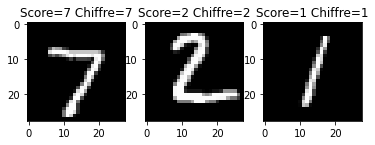

In [62]:
classes_predites = model.predict_classes(test_images)
correct_indices = np.nonzero(classes_predites == test_labels)[0]
incorrect_indices = np.nonzero(classes_predites != test_labels)[0]

plt.figure()
for i, correct in enumerate(correct_indices[:3]):
    plt.subplot(1,3,i+1)
    plt.imshow(test_images[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Score={} Chiffre={}".format(classes_predites[correct], test_labels[correct]))

### Erreurs du modèle :

In [63]:
incorrect_indices

array([ 247,  321,  340,  366,  445,  449,  582,  583,  591,  619,  659,
        684,  691,  720,  938,  947,  951,  956,  965,  992, 1014, 1039,
       1112, 1114, 1181, 1182, 1226, 1232, 1242, 1247, 1260, 1289, 1299,
       1319, 1337, 1393, 1444, 1494, 1500, 1522, 1527, 1530, 1531, 1549,
       1553, 1609, 1681, 1717, 1751, 1754, 1790, 1828, 1901, 1940, 1941,
       1952, 1982, 1984, 1987, 2016, 2018, 2024, 2043, 2044, 2053, 2063,
       2070, 2073, 2098, 2109, 2118, 2130, 2135, 2174, 2182, 2185, 2189,
       2224, 2272, 2293, 2387, 2406, 2414, 2433, 2447, 2454, 2488, 2514,
       2607, 2648, 2654, 2720, 2877, 2896, 2907, 2939, 2953, 2979, 3030,
       3062, 3073, 3117, 3289, 3422, 3474, 3503, 3520, 3533, 3549, 3558,
       3567, 3681, 3727, 3757, 3780, 3796, 3808, 3811, 3818, 3838, 3853,
       3869, 3893, 3906, 3941, 3943, 3976, 4065, 4078, 4176, 4199, 4201,
       4224, 4248, 4289, 4355, 4425, 4437, 4443, 4497, 4536, 4578, 4740,
       4761, 4807, 4814, 4823, 4860, 4880, 4890, 49

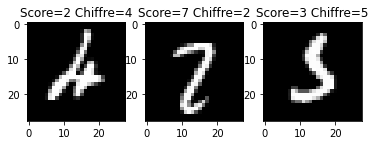

In [64]:
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:3]):
    plt.subplot(1,3,i+1)
    plt.imshow(test_images[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Score={} Chiffre={}".format(classes_predites[incorrect], test_labels[incorrect]))

<img src="https://github.com/retkowsky/images/blob/master/Powered-by-MS-Azure-logo-v2.png?raw=true" height="300" width="300">